In [1]:
import os

os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

# Evaluation
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    make_scorer
)

# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Other
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from skmultilearn.model_selection import IterativeStratification

# Classifiers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from src.models.evaluation import evaluation
from src.data.iterative_train_test_split import iterative_train_test_split

In [3]:
pd.set_option("display.max_rows", 5)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 100)

## 1. Load and transform data

In [4]:
# Load data
df = pd.read_pickle("data/processed/reports_tokenized.p")
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 HOLDINGS PLC\n\nANNUAL REPORT & ACCOUNTS 2020\n\n A YEAR OF \nSTRONG GROWTH \n\n888 IS ONE ...,888 ORG ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH ORG IS ONE OF THE WORLDS LEADING O...,org annual report account year strong growth org one world leading online betting gaming company...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on \nour Promises\n\n2020 Corporate Social Responsibility Report\n\n1\n\n Letter fro...,Delivering on our Promises 2020 Corporate ORG 1 Letter from the President Stakeholder engagement...,delivering promise corporate org letter president stakeholder engagement environment table conte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8101,8101,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...,sustainability report company profile corporate overview purpose mission value sustainability co...
8102,8102,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...,sustainability report investing future world letter ceo stakeholder company profile corporate ov...


In [5]:
# Transform labels to numpy array: Exclude SDGs 2 and 9 (too few aligned examples) and 10 and 14 (no mapping) -> 13 labels left
labels = [
    "SDG_1",
    "SDG_3",
    "SDG_4",
    "SDG_5",
    "SDG_6",
    "SDG_7",
    "SDG_8",
    "SDG_11",
    "SDG_12",
    "SDG_13",
    "SDG_15",
    "SDG_16",
    "SDG_17",
]
Y = df[labels].to_numpy().astype(int)

In [6]:
# Split into 80% training and 20% test data (stratified for multi-label, adapted to work with df column)

np.random.seed(7)

X_train, Y_train, X_test, Y_test = iterative_train_test_split(df['CSR_Text_tokenized'], Y, test_size=0.2)

## 2. Classification with balanced weights

### 2.1. Logistic Regression

In [7]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'tfidf__min_df': [1, 5, 10], # Ignore terms that appear in less than 1/ 5/ 10 of the documents
    'clf__estimator__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_lr = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_lr.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_lr.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_lr.best_score_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 5/5] END clf__estimator__C=0.1, tfidf__min_df=1;, score=0.748 total time=12.1min
[CV 5/5] END clf__estimator__C=0.1, tfidf__min_df=10;, score=0.746 total time= 4.5min
[CV 3/5] END clf__estimator__C=1, tfidf__min_df=5;, score=0.850 total time= 8.2min
[CV 5/5] END clf__estimator__C=1, tfidf__min_df=5;, score=0.834 total time= 7.9min
[CV 4/5] END clf__estimator__C=1, tfidf__min_df=10;, score=0.827 total time= 5.5min
[CV 2/5] END clf__estimator__C=10, tfidf__min_df=5;, score=0.892 total time=14.3min
[CV 4/5] END clf__estimator__C=10, tfidf__min_df=5;, score=0.886 total time=12.5min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 3/5] END clf__estimator__C=10, tfidf__min_df=10;, score=0.895 total time= 9.2min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 4/5] END clf__estimator__C=0.1, tfidf__min_df=1;, score=0.750 total time=12.3min
[CV 3/5] END clf__estimator__C=1, tfidf__min_df=1;, score=0.849 total time=26.0min
[CV 1/5] END clf__estimator__C=10, tfidf__min_df=5;, score=0.874 total time=14.6min
[CV 5/5] END clf__estimator__C=10, tfidf__min_df=5;, score=0.884 total time=12.9min
[CV 4/5] END clf__estimator__C=10, tfidf__min_df=10;, score=0.883 total time= 9.3min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 2/5] END clf__estimator__C=0.1, tfidf__min_df=1;, score=0.752 total time=12.3min
[CV 2/5] END clf__estimator__C=1, tfidf__min_df=1;, score=0.833 total time=23.0min
[CV 1/5] END clf__estimator__C=10, tfidf__min_df=1;, score=0.878 total time=44.2min
[CV 3/5] END clf__estimator__C=0.1, tfidf__min_df=1;, score=0.765 total time=12.2min
[CV 1/5] END clf__estimator__C=1, tfidf__min_df=1;, score=0.831 total time=22.4min
[CV 5/5] END clf__estimator__C=1, tfidf__min_df=10;, score=0.830 total time= 5.6min
[CV 3/5] END clf__estimator__C=10, tfidf__min_df=5;, score=0.895 total time=14.1min
[CV 1/5] END clf__estimator__C=10, tfidf__min_df=10;, score=0.869 total time= 9.2min
[CV 2/5] END clf__estimator__C=10, tfidf__min_df=10;, score=0.889 total time= 8.9min
[CV 5/5] END clf__estimator__C=10, tfidf__min_df=10;, score=0.884 total time= 9.7min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 1/5] END clf__estimator__C=0.1, tfidf__min_df=1;, score=0.751 total time=13.3min
[CV 4/5] END clf__estimator__C=1, tfidf__min_df=1;, score=0.835 total time=24.8min
[CV 4/5] END clf__estimator__C=10, tfidf__min_df=1;, score=0.887 total time=46.2min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 1/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.751 total time= 5.3min
[CV 5/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.749 total time= 6.7min
[CV 4/5] END clf__estimator__C=0.1, tfidf__min_df=10;, score=0.751 total time= 4.2min
[CV 2/5] END clf__estimator__C=1, tfidf__min_df=5;, score=0.829 total time= 9.0min
[CV 1/5] END clf__estimator__C=1, tfidf__min_df=10;, score=0.825 total time= 6.1min
[CV 2/5] END clf__estimator__C=1, tfidf__min_df=10;, score=0.825 total time= 5.8min
[CV 2/5] END clf__estimator__C=10, tfidf__min_df=1;, score=0.895 total time=47.9min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 2/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.749 total time= 4.9min
[CV 4/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.751 total time= 6.2min
[CV 3/5] END clf__estimator__C=0.1, tfidf__min_df=10;, score=0.764 total time= 4.1min
[CV 1/5] END clf__estimator__C=1, tfidf__min_df=5;, score=0.830 total time= 8.3min
[CV 4/5] END clf__estimator__C=1, tfidf__min_df=5;, score=0.834 total time= 8.0min
[CV 3/5] END clf__estimator__C=1, tfidf__min_df=10;, score=0.843 total time= 5.7min
[CV 3/5] END clf__estimator__C=10, tfidf__min_df=1;, score=0.901 total time=47.8min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 3/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.767 total time= 5.6min
[CV 1/5] END clf__estimator__C=0.1, tfidf__min_df=10;, score=0.749 total time= 5.1min
[CV 2/5] END clf__estimator__C=0.1, tfidf__min_df=10;, score=0.746 total time= 4.3min
[CV 5/5] END clf__estimator__C=1, tfidf__min_df=1;, score=0.836 total time=23.0min
[CV 5/5] END clf__estimator__C=10, tfidf__min_df=1;, score=0.888 total time=47.4min
Best Parameters: {'clf__estimator__C': 10, 'tfidf__min_df': 1}
Mean cross-validated F1-score of the best estimator: 0.8898221302523945


              precision    recall  f1-score   support

           0       0.74      0.65      0.69       205
           1       0.89      0.93      0.91      1483
           2       0.85      0.91      0.88      1435
           3       0.86      0.90      0.88      1311
           4       0.91      0.85      0.88      1411
           5       0.90      0.83      0.86      1309
           6       0.86      0.88      0.87      1227
           7       0.72      0.63      0.67       199
           8       0.91      0.89      0.90      1528
           9       0.85      0.75      0.80      1144
          10       0.83      0.77      0.80       582
          11       0.86      0.85      0.86      1251
          12       0.72      0.63      0.67       199

   micro avg       0.87      0.85      0.86     13284
   macro avg       0.84      0.81      0.82     13284
weighted avg       0.87      0.85      0.86     13284
 samples avg       0.86      0.84      0.82     13284



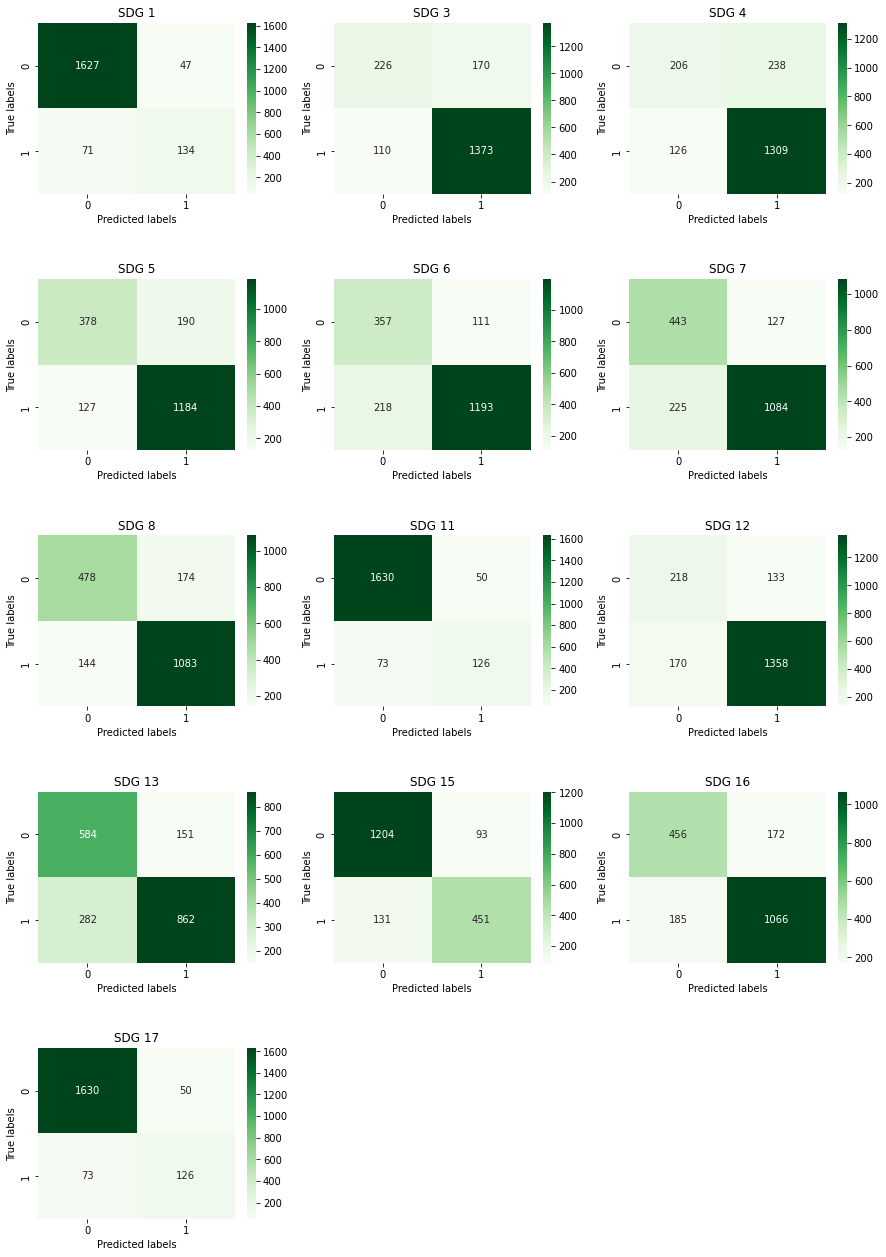

In [8]:
evaluation(grid_lr, X_test, Y_test)

In [15]:
# Look at 10 most important words for each SDG (LR masked)
i = 0
tfidf = grid_lr.best_estimator_.named_steps["tfidf"].get_feature_names()
for sdg in labels:
    coefs = grid_lr.best_estimator_.named_steps["clf"].estimators_[i].coef_[0]
    important_tokens = pd.DataFrame(data = coefs, index=tfidf, columns=['coefficient']).sort_values(by='coefficient', ascending=False)
    print(sdg)
    print(list(important_tokens.index)[0:10])
    print('\n')
    i += 1

SDG_1
['banking', 'medicine', 'loan', 'bank', 'financial', 'lending', 'patient', 'ni', 'org smith', 'customer']


SDG_3
['safety', 'supplier', 'health', 'mine', 'responsibility report', 'tax', 'chain', 'operation', 'report account', 'training']


SDG_4
['training', 'gri', 'risk', 'supplier', 'learning', 'emission', 'management', 'fy fy', 'development', 'tax']


SDG_5
['supplier', 'human right', 'global', 'right', 'goal', 'human', 'sustainable', 'labor', 'chain', 'supply chain']


SDG_6
['water', 'site', 'supplier', 'chain', 'product', 'goal', 'manufacturing', 'supply chain', 'supply', 'rub']


SDG_7
['energy', 'renewable', 'global', 'million', 'renewable energy', 'solar', 'sustainable', 'carbon', 'product', 'santos']


SDG_8
['human right', 'right', 'human', 'supplier', 'global', 'labor', 'covid', 'goal', 'risk', 'chain']


SDG_11
['banking', 'medicine', 'financial', 'lending', 'patient', 'bank', 'ni', 'org smith', 'million', 'customer']


SDG_12
['supplier', 'waste', 'energy', 'chain'

### 2.2. Linear SVM

In [7]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('clf', OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'tfidf__min_df': [1, 5, 10], # Ignore terms that appear in less than 1/ 5/ 10 of the documents
    'clf__estimator__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_svm = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_svm.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_svm.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_svm.best_score_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 3/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.774 total time=314.1min
[CV 1/5] END clf__estimator__C=0.1, tfidf__min_df=10;, score=0.757 total time=279.5min
[CV 2/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.760 total time=309.7min
[CV 4/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.755 total time=307.9min
[CV 1/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.759 total time=313.1min
[CV 5/5] END clf__estimator__C=0.1, tfidf__min_df=5;, score=0.755 total time=314.2min
[CV 1/5] END clf__estimator__C=0.1, tfidf__min_df=1;, score=0.757 total time=369.7min
[CV 2/5] END clf__estimator__C=0.1, tfidf__min_df=10;, score=0.760 total time=275.1min
[CV 2/5] END clf__estimator__C=0.1, tfidf__min_df=1;, score=0.758 total time=369.7min
[CV 3/5] END clf__estimator__C=0.1, tfidf__min_df=10;, score=0.773 total time=284.2min
[CV 5/5] END clf__estimator__C=0.1, tfidf__min_df=1;, score=0.752 total time=

              precision    recall  f1-score   support

           0       0.85      0.62      0.72       205
           1       0.86      0.97      0.91      1483
           2       0.83      0.94      0.88      1435
           3       0.82      0.95      0.88      1311
           4       0.88      0.92      0.90      1411
           5       0.86      0.90      0.88      1309
           6       0.84      0.92      0.88      1227
           7       0.85      0.60      0.71       199
           8       0.88      0.95      0.91      1528
           9       0.83      0.82      0.83      1144
          10       0.85      0.79      0.82       582
          11       0.83      0.92      0.87      1251
          12       0.85      0.60      0.71       199

   micro avg       0.85      0.90      0.88     13284
   macro avg       0.85      0.84      0.84     13284
weighted avg       0.85      0.90      0.87     13284
 samples avg       0.84      0.90      0.84     13284



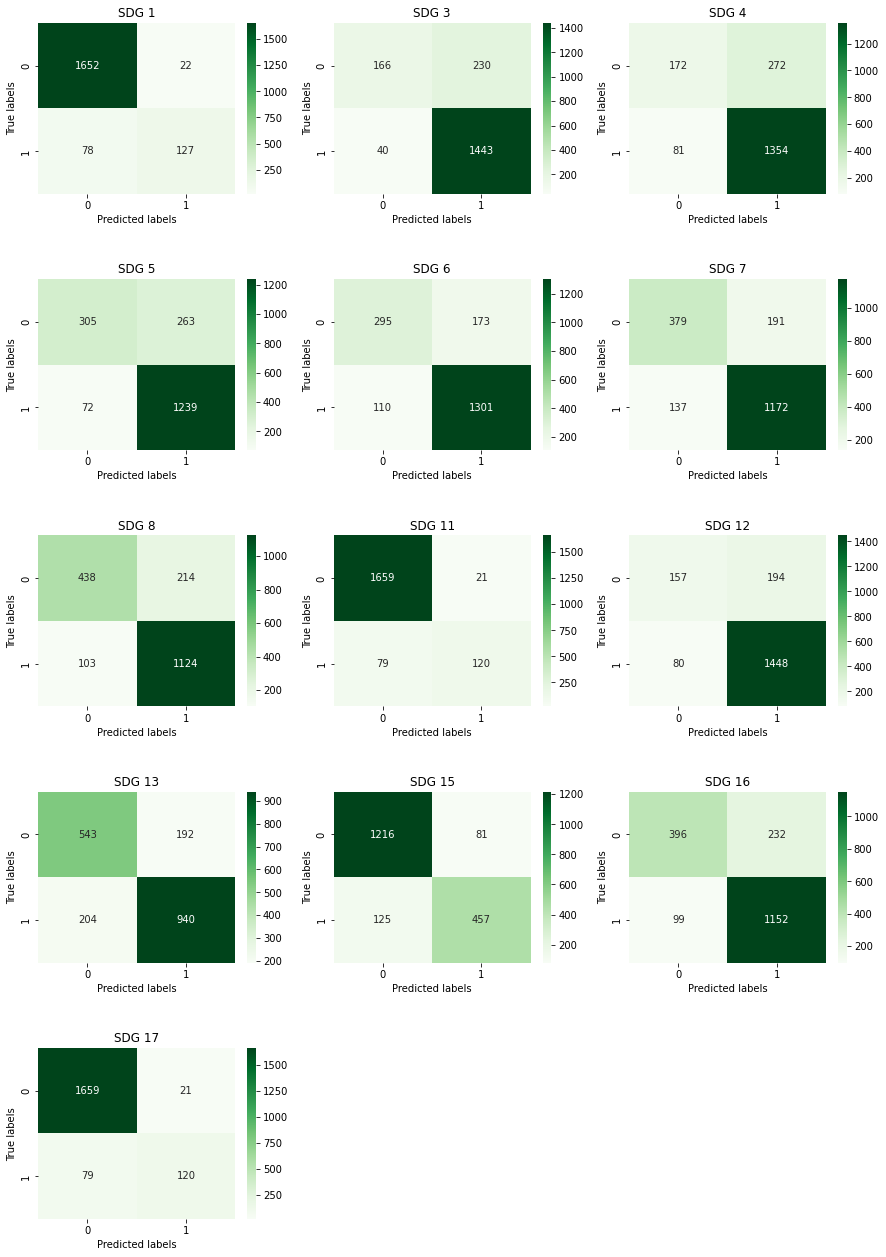

In [8]:
evaluation(grid_svm, X_test, Y_test)

### 2.3. Random Forest

In [9]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('clf', OneVsRestClassifier(RandomForestClassifier(class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'tfidf__min_df': [1, 5, 10], # Ignore terms that appear in less than 1/ 5/ 10 of the documents
    'clf__estimator__n_estimators': [50, 100], # Number of trees in the forest
    'clf__estimator__max_depth': [10, 20, None] # Maximum depth of the tree
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_rf = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_rf.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_rf.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_rf.best_score_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 4/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=50, tfidf__min_df=1;, score=0.764 total time=11.9min
[CV 1/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100, tfidf__min_df=1;, score=0.772 total time=19.1min
[CV 5/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100, tfidf__min_df=10;, score=0.802 total time= 6.4min
[CV 3/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50, tfidf__min_df=5;, score=0.763 total time=12.0min
[CV 1/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50, tfidf__min_df=10;, score=0.761 total time= 7.1min
[CV 3/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50, tfidf__min_df=10;, score=0.772 total time= 8.3min
[CV 1/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=100, tfidf__min_df=1;, score=0.751 total time=65.4min
[CV 3/5] END clf__estimator__max_depth=None, clf__estimato

[CV 3/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=50, tfidf__min_df=1;, score=0.785 total time=13.2min
[CV 3/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100, tfidf__min_df=1;, score=0.794 total time=22.8min
[CV 1/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50, tfidf__min_df=5;, score=0.763 total time=10.2min
[CV 4/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50, tfidf__min_df=5;, score=0.762 total time=10.3min
[CV 2/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50, tfidf__min_df=10;, score=0.774 total time= 8.0min
[CV 5/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50, tfidf__min_df=10;, score=0.778 total time= 8.8min
[CV 4/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=100, tfidf__min_df=1;, score=0.745 total time=73.3min
[CV 1/5] END clf__estimator__max_depth=None, clf__estimator__n_estimators=50, tfidf__min_df=5;, score=0.750 total time=19

              precision    recall  f1-score   support

           0       0.78      0.36      0.49       205
           1       0.88      0.88      0.88      1483
           2       0.84      0.88      0.86      1435
           3       0.84      0.82      0.83      1311
           4       0.90      0.73      0.81      1411
           5       0.86      0.72      0.78      1309
           6       0.84      0.79      0.81      1227
           7       0.84      0.35      0.49       199
           8       0.90      0.84      0.87      1528
           9       0.81      0.64      0.72      1144
          10       0.78      0.53      0.63       582
          11       0.83      0.74      0.78      1251
          12       0.78      0.34      0.48       199

   micro avg       0.85      0.76      0.80     13284
   macro avg       0.84      0.66      0.73     13284
weighted avg       0.85      0.76      0.80     13284
 samples avg       0.80      0.73      0.72     13284



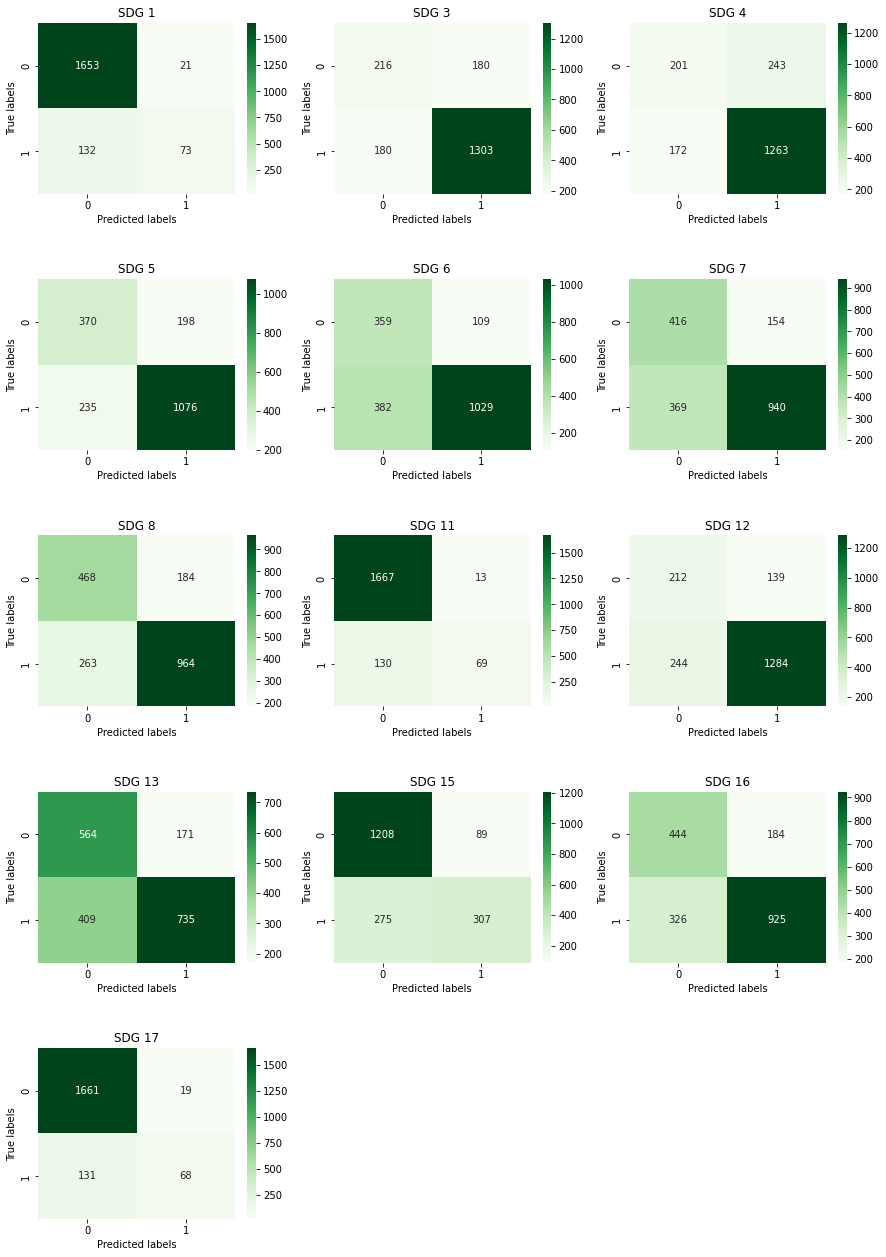

In [10]:
evaluation(grid_rf, X_test, Y_test)

## 3. Repeat classification with unmasked text
(No parameter tuning, use same parameters as before to obtain comparable restuls)

In [15]:
# Load data
df = pd.read_pickle("data/processed/reports_tokenized_unmasked.p")
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 HOLDINGS PLC ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH 888 IS ONE OF THE WORLDS ...,holding plc annual report account year strong growth one world leading online betting gaming com...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on our Promises 2020 Corporate Social Responsibility Report 1 Letter from the Preside...,delivering promise corporate social responsibility report letter president stakeholder engagemen...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8101,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...,sustainability report company profile corporate overview purpose mission value sustainability co...
8102,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...,sustainability report investing future world letter ceo stakeholder company profile corporate ov...


In [16]:
# Transform labels to numpy array: Exclude SDGs 2 and 9 (too few aligned examples) and 10 and 14 (no mapping) -> 13 labels left
labels = [
    "SDG_1",
    "SDG_3",
    "SDG_4",
    "SDG_5",
    "SDG_6",
    "SDG_7",
    "SDG_8",
    "SDG_11",
    "SDG_12",
    "SDG_13",
    "SDG_15",
    "SDG_16",
    "SDG_17",
]
Y = df[labels].to_numpy().astype(int)

In [17]:
# Split into 80% training and 20% test data (stratified for multi-label, adapted to work with df column)

np.random.seed(7)

X_train, Y_train, X_test, Y_test = iterative_train_test_split(df['CSR_Text_tokenized'], Y, test_size=0.2)

### 3.1. Logistic Regression

In [19]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'tfidf__min_df': [1], # Ignore terms that appear in less than 1/ 5/ 10 of the documents
    'clf__estimator__C': [10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=2, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_lr = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_lr.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_lr.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_lr.best_score_))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END clf__estimator__C=10, tfidf__min_df=1;, score=0.890 total time=32.6min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/2] END clf__estimator__C=10, tfidf__min_df=1;, score=0.890 total time=42.0min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Best Parameters: {'clf__estimator__C': 10, 'tfidf__min_df': 1}
Mean cross-validated F1-score of the best estimator: 0.8897848906135561


              precision    recall  f1-score   support

           0       0.78      0.71      0.75       205
           1       0.89      0.93      0.91      1483
           2       0.85      0.90      0.88      1435
           3       0.85      0.91      0.88      1311
           4       0.92      0.87      0.90      1411
           5       0.90      0.85      0.88      1309
           6       0.85      0.89      0.87      1227
           7       0.79      0.70      0.74       199
           8       0.91      0.91      0.91      1528
           9       0.84      0.78      0.81      1144
          10       0.83      0.80      0.81       582
          11       0.85      0.86      0.86      1251
          12       0.79      0.70      0.74       199

   micro avg       0.87      0.87      0.87     13284
   macro avg       0.85      0.83      0.84     13284
weighted avg       0.87      0.87      0.87     13284
 samples avg       0.86      0.86      0.83     13284



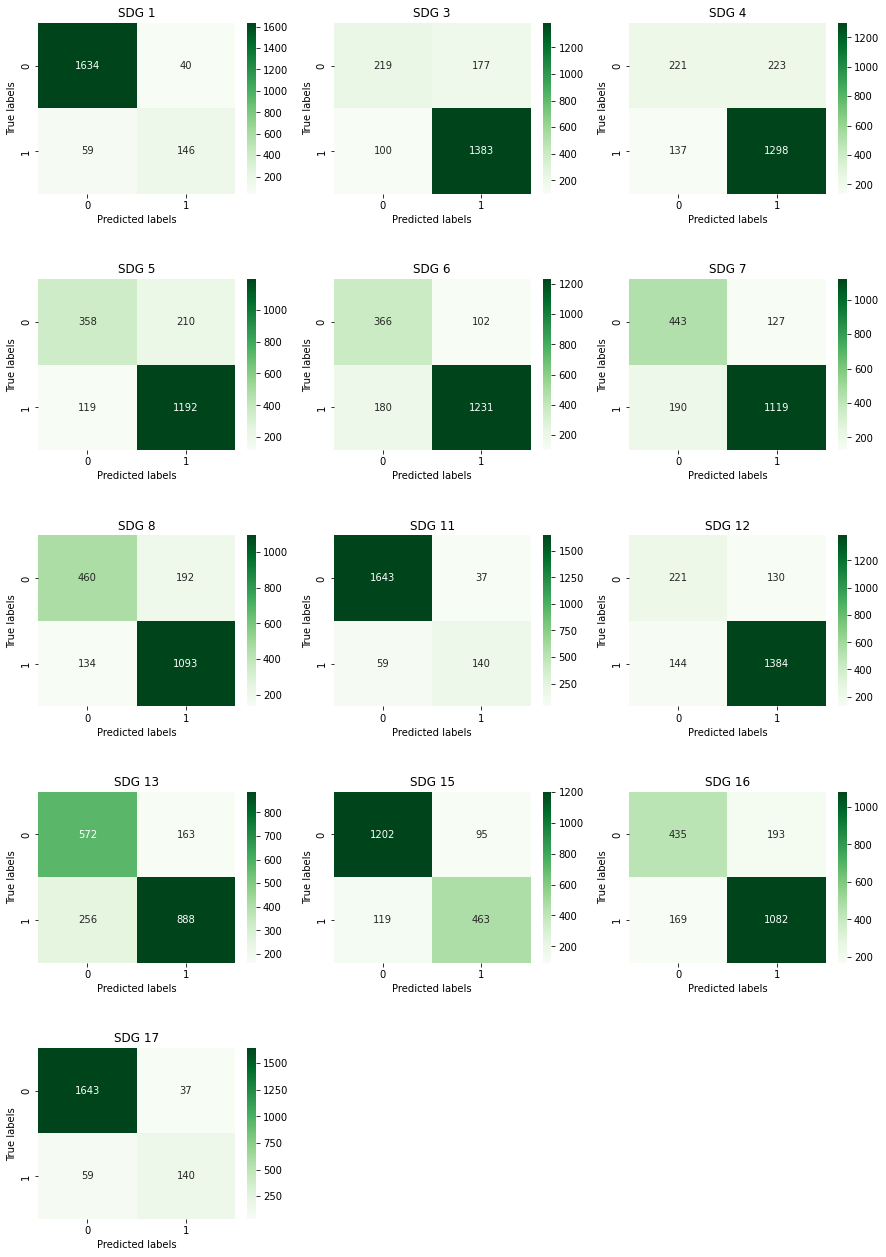

In [20]:
evaluation(grid_lr, X_test, Y_test)

In [21]:
# Look at 10 most important words for each SDG (LR unmasked)
i = 0
tfidf = grid_lr.best_estimator_.named_steps["tfidf"].get_feature_names()
for sdg in labels:
    coefs = grid_lr.best_estimator_.named_steps["clf"].estimators_[i].coef_[0]
    important_tokens = pd.DataFrame(data = coefs, index=tfidf, columns=['coefficient']).sort_values(by='coefficient', ascending=False)
    print(sdg)
    print(list(important_tokens.index)[0:10])
    print('\n')
    i += 1

SDG_1
['banking', 'bank', 'kb', 'jetblue', 'novartis', 'financial', 'vodafone', 'stagecoach', 'allstate', 'rbc']


SDG_3
['safety', 'supplier', 'health', 'water', 'operation', 'chain', 'mine', 'responsibility report', 'mining', 'supply']


SDG_4
['supplier', 'employee', 'training', 'risk', 'gri', 'client', 'climate', 'emission', 'percent', 'management']


SDG_5
['supplier', 'global', 'human right', 'right', 'human', 'goal', 'chain', 'supply chain', 'risk', 'sustainable']


SDG_6
['water', 'supplier', 'gri', 'product', 'chain', 'site', 'supply', 'supply chain', 'goal', 'cibc']


SDG_7
['energy', 'renewable', 'global', 'sustainable', 'product', 'million', 'solar', 'renewable energy', 'carbon', 'gri']


SDG_8
['human right', 'right', 'human', 'supplier', 'global', 'chain', 'covid', 'risk', 'supply chain', 'labor']


SDG_11
['banking', 'kb', 'bank', 'financial', 'jetblue', 'novartis', 'vodafone', 'rbc', 'allstate', 'stagecoach']


SDG_12
['supplier', 'waste', 'energy', 'global', 'chain', '

### 3.2. Linear SVM

In [18]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('clf', OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'tfidf__min_df': [1], # Ignore terms that appear in less than 1/ 5/ 10 of the documents
    'clf__estimator__C': [10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=2, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_svm = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_svm.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_svm.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_svm.best_score_))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END clf__estimator__C=10, tfidf__min_df=1;, score=0.903 total time=197.0min
[CV 2/2] END clf__estimator__C=10, tfidf__min_df=1;, score=0.897 total time=197.0min
Best Parameters: {'clf__estimator__C': 10, 'tfidf__min_df': 1}
Mean cross-validated F1-score of the best estimator: 0.8998527811694205


              precision    recall  f1-score   support

           0       0.84      0.70      0.76       205
           1       0.87      0.97      0.92      1483
           2       0.84      0.93      0.89      1435
           3       0.83      0.94      0.88      1311
           4       0.89      0.92      0.91      1411
           5       0.86      0.89      0.88      1309
           6       0.83      0.91      0.87      1227
           7       0.84      0.69      0.75       199
           8       0.89      0.95      0.92      1528
           9       0.83      0.83      0.83      1144
          10       0.83      0.81      0.82       582
          11       0.83      0.92      0.87      1251
          12       0.84      0.69      0.75       199

   micro avg       0.85      0.91      0.88     13284
   macro avg       0.85      0.86      0.85     13284
weighted avg       0.85      0.91      0.88     13284
 samples avg       0.84      0.90      0.85     13284



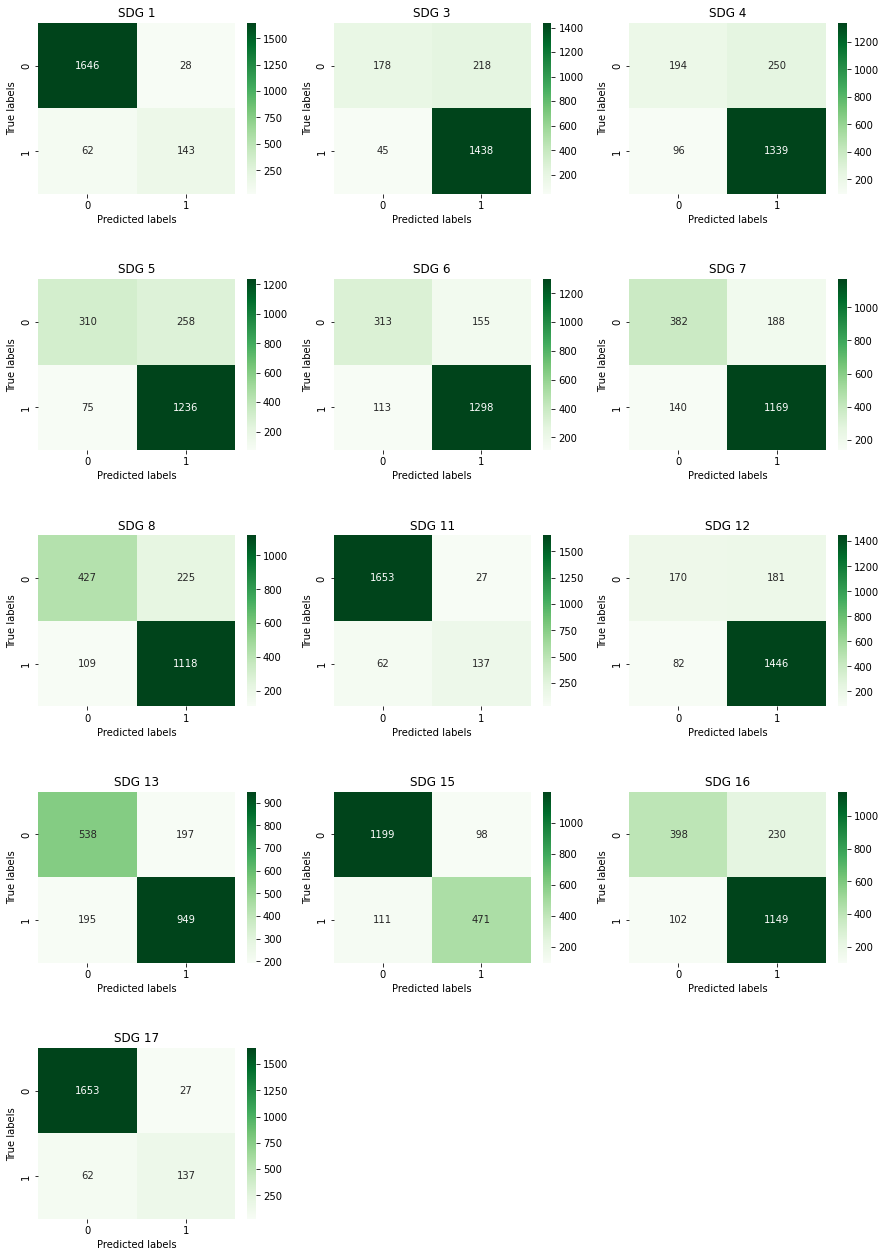

In [19]:
evaluation(grid_svm, X_test, Y_test)

### 3.3. Random Forest

In [20]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('clf', OneVsRestClassifier(RandomForestClassifier(class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'tfidf__min_df': [10], # Ignore terms that appear in less than 1/ 5/ 10 of the documents
    'clf__estimator__n_estimators': [100], # Number of trees in the forest
    'clf__estimator__max_depth': [10] # Maximum depth of the tree
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_rf = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_rf.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_rf.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_rf.best_score_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 3/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100, tfidf__min_df=10;, score=0.814 total time= 5.5min
[CV 2/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100, tfidf__min_df=10;, score=0.818 total time= 5.7min
[CV 1/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100, tfidf__min_df=10;, score=0.789 total time= 5.8min
[CV 4/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100, tfidf__min_df=10;, score=0.797 total time= 5.9min
[CV 5/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100, tfidf__min_df=10;, score=0.808 total time= 6.2min
Best Parameters: {'clf__estimator__max_depth': 10, 'clf__estimator__n_estimators': 100, 'tfidf__min_df': 10}
Mean cross-validated F1-score of the best estimator: 0.804960758032429


              precision    recall  f1-score   support

           0       0.77      0.37      0.50       205
           1       0.89      0.88      0.89      1483
           2       0.84      0.88      0.86      1435
           3       0.85      0.83      0.84      1311
           4       0.90      0.74      0.81      1411
           5       0.88      0.73      0.80      1309
           6       0.86      0.79      0.82      1227
           7       0.74      0.36      0.48       199
           8       0.91      0.86      0.88      1528
           9       0.82      0.65      0.73      1144
          10       0.80      0.55      0.65       582
          11       0.83      0.76      0.79      1251
          12       0.77      0.37      0.50       199

   micro avg       0.86      0.77      0.81     13284
   macro avg       0.84      0.68      0.74     13284
weighted avg       0.86      0.77      0.81     13284
 samples avg       0.82      0.74      0.74     13284



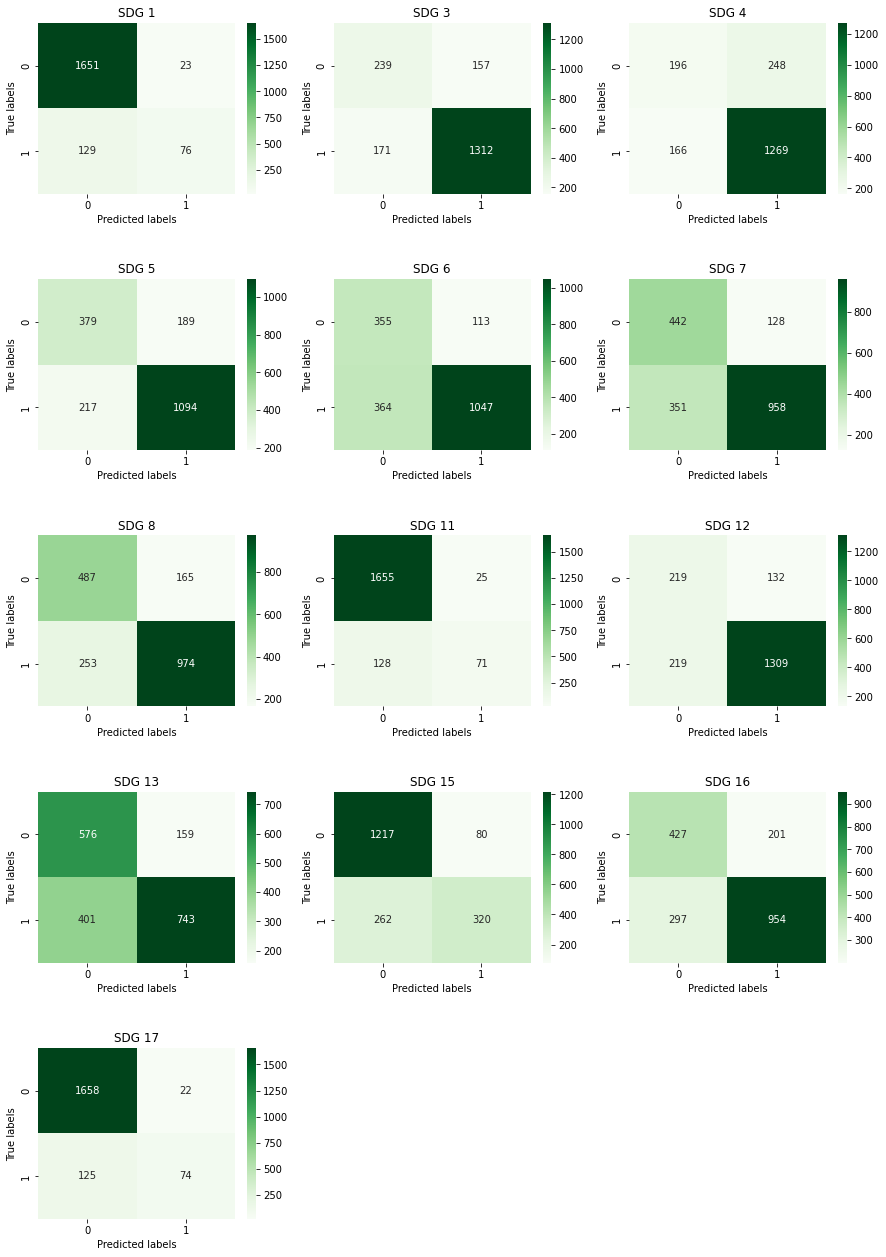

In [21]:
evaluation(grid_rf, X_test, Y_test)